In [20]:
#All the following script and comments have been made in accordance to single cell  data analysis##

#Importing packages # Make sure that you activate correct environment 
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

#writing output file
results_file = "./outputs/heart_immune_scanpy.h5ad"

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [21]:
#Reading the h5ad file
immune = sc.read_h5ad('./hca_heart_immune_download.h5ad')
immune

AnnData object with n_obs × n_vars = 40868 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'type', 'version', 'scNym', 'scNym_confidence'
    uns: 'cell_states_colors', 'scNym_colors', 'scNym_probabilities'
    obsm: 'X_pca', 'X_scnym', 'X_umap'

normalizing counts per cell
    finished (0:00:00)


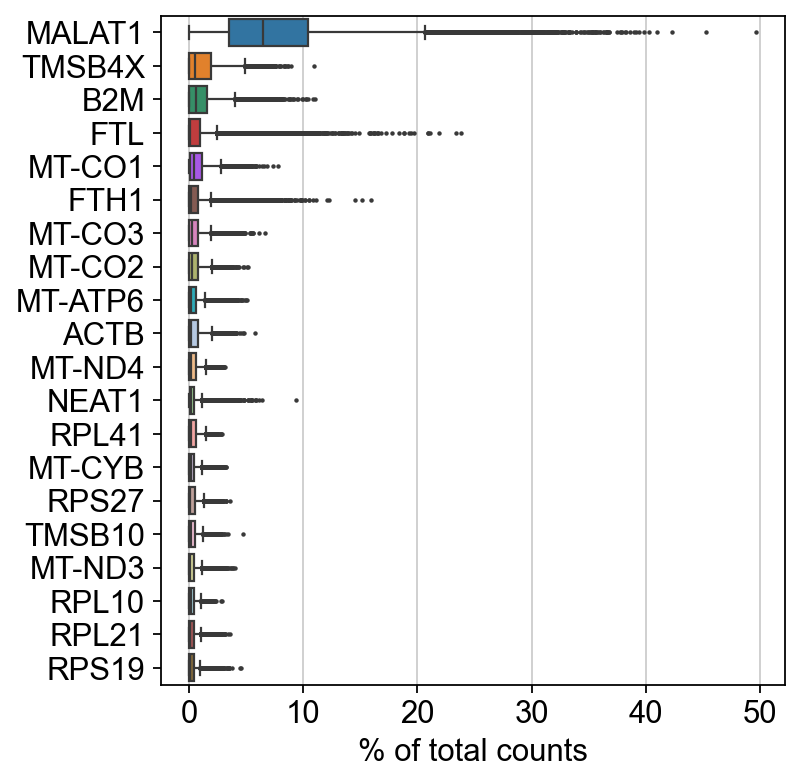

filtered out 6863 genes that are detected in less than 3 cells


In [22]:
#PREPROCESSING#

#Viewing genes that contributes the largest portion in a cell
sc.pl.highest_expr_genes(immune, n_top=20)

#Filtering genes and cells
sc.pp.filter_cells(immune, min_genes=200)
sc.pp.filter_genes(immune, min_cells=3)

#Above filtering considers only cells having min 200 genes as a primary criteria and filters the genes which are found in minimum of 3 cells

In [23]:
# Selecting the group of mitochondrial genes -- GENES OF INTEREST
immune.var["mt"] = immune.var_names.str.startswith("MT-")
immune.var

#Calculating desired metrics 
sc.pp.calculate_qc_metrics(immune, qc_vars=["mt"], percent_top=None, log1p=False, inplace = True)

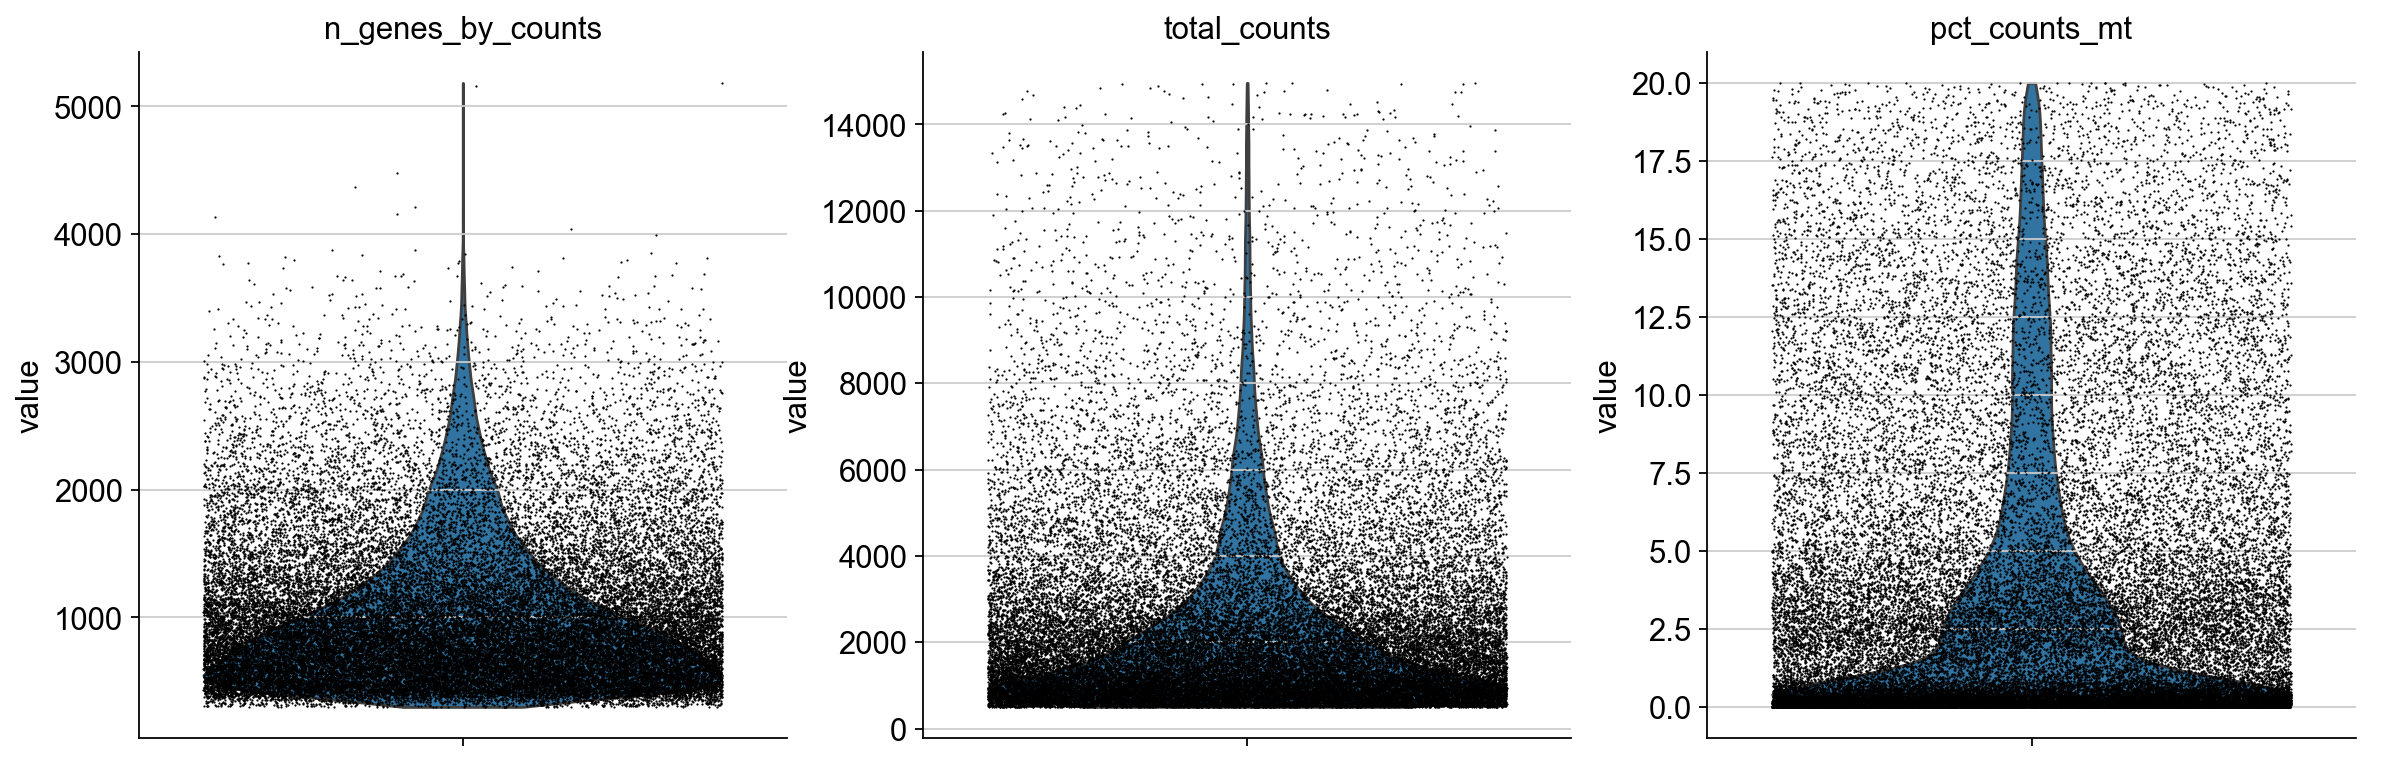

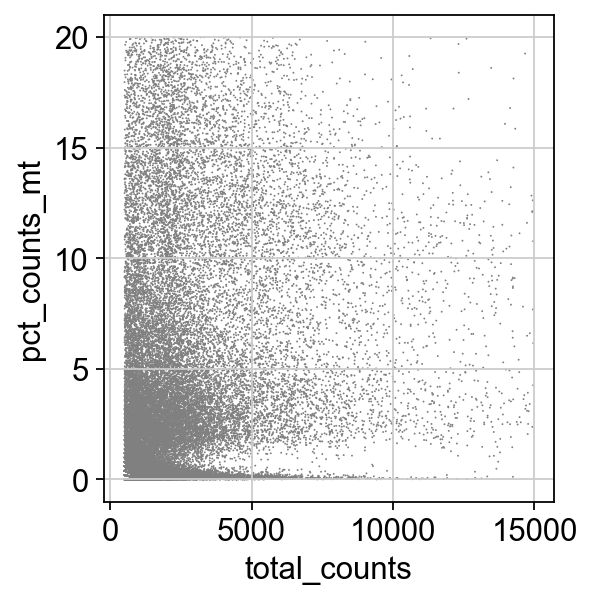

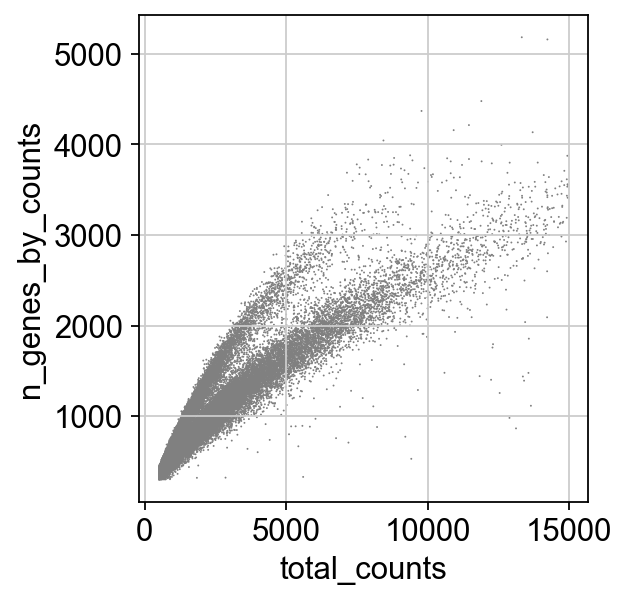

In [24]:
#Graphical representation of data

#Violin plots
sc.pl.violin(immune,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.4,multi_panel=True)

#Scatter plots
sc.pl.scatter(immune, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(immune, x="total_counts", y="n_genes_by_counts")

In [25]:
# If we want to slice/Filter the data

#Based on number of genes
immune = immune[immune.obs.n_genes_by_counts < 2500, :]

#Based on percentage of mitochondrial genes
immune = immune[immune.obs.pct_counts_mt < 5, :].copy()

#Normalizing data matrix using CPM
sc.pp.normalize_total(immune,target_sum=1e6)

#Logarithmization of data
sc.pp.log1p(immune,base=2)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes


/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


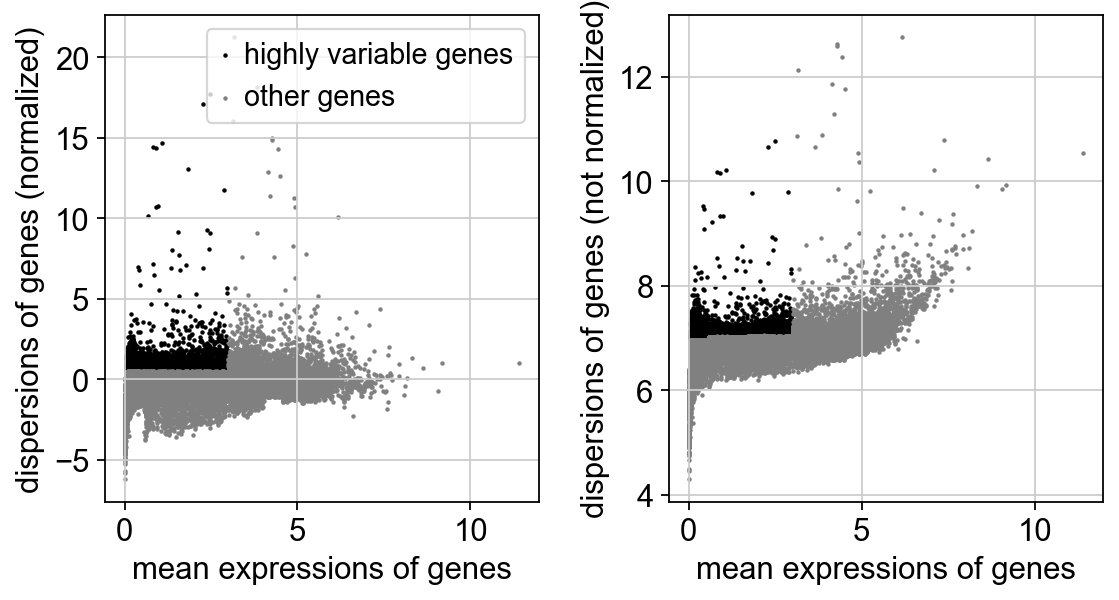

In [26]:
#Identifying high variable genes
sc.pp.highly_variable_genes(immune, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(immune)

In [27]:
#Saving data as a backup so we wont loose it later

#Saving normalized and logarithmic data which is not corrected as raw

immune.raw = immune

In [28]:
#Scaling data
#Filtering or selecting columns (genes) based on the highly variable genes identified
immune = immune[:, immune.var.highly_variable]

#Regression of data i.e., Removing batch effects based on criteria of interest
sc.pp.regress_out(immune, ["total_counts", "pct_counts_mt"])

#Scaling gene expression to make it comparable across cells
sc.pp.scale(immune, max_value=10)

#To view it
immune

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:47)


AnnData object with n_obs × n_vars = 28892 × 5112
    obs: 'NRP', 'age_group', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'type', 'version', 'scNym', 'scNym_confidence', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_states_colors', 'scNym_colors', 'scNym_probabilities', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_scnym', 'X_umap'

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:14)


/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


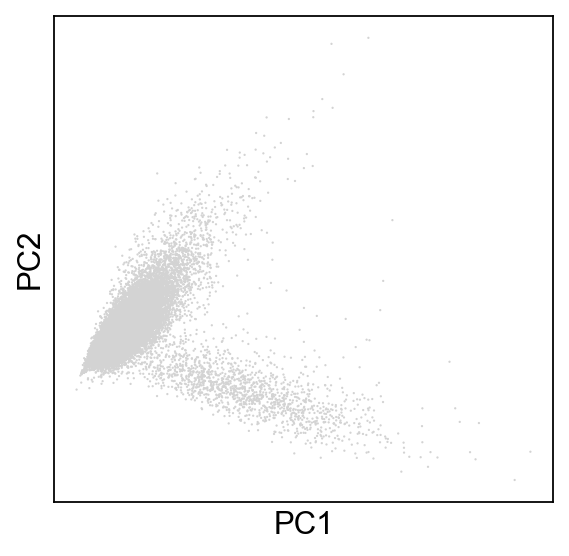

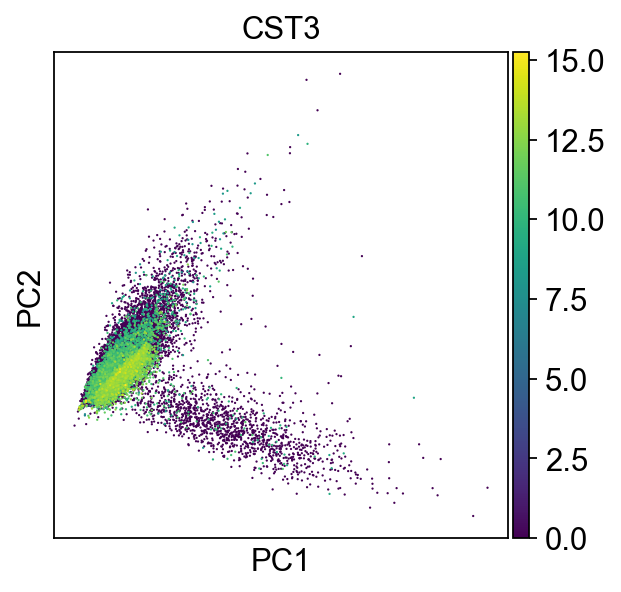

In [29]:
##PRINCIPAL COMPONENT ANALYSIS##

#Reducing dimensions
sc.tl.pca(immune, svd_solver="arpack")

#To view the principal components
immune.obsm['X_pca']

#Scatter plot for PCA components for visualization 
sc.pl.pca(immune)

#Scatter plot for PCA components for visualization based on coloring of genes
sc.pl.pca(immune,color= "CST3")

In [30]:
#Number of PCs to be considered for the data
sc.tl.tsne(immune)

#To know the values and count of Principal components
immune.obsm['X_pca']

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:27)


array([[ 0.14098136,  2.2257862 , -1.5337257 , ..., -0.25429103,
        -1.1964035 , -0.67895186],
       [-1.239512  , -0.27373457, -0.54187965, ...,  0.8637631 ,
         0.15006468,  1.2393273 ],
       [-0.6713821 ,  1.1900164 , -0.4475229 , ..., -0.11283452,
        -0.02974981,  0.5553413 ],
       ...,
       [ 2.0240037 ,  1.4310461 ,  1.4154415 , ..., -0.4494064 ,
        -1.1350365 ,  0.00839099],
       [ 1.4129076 ,  1.3027153 ,  0.45455682, ...,  0.10547179,
        -0.22978188,  0.27902827],
       [ 0.80011654, -1.5479987 , -5.3127394 , ...,  0.30682364,
         0.79160064, -0.3511631 ]], dtype=float32)

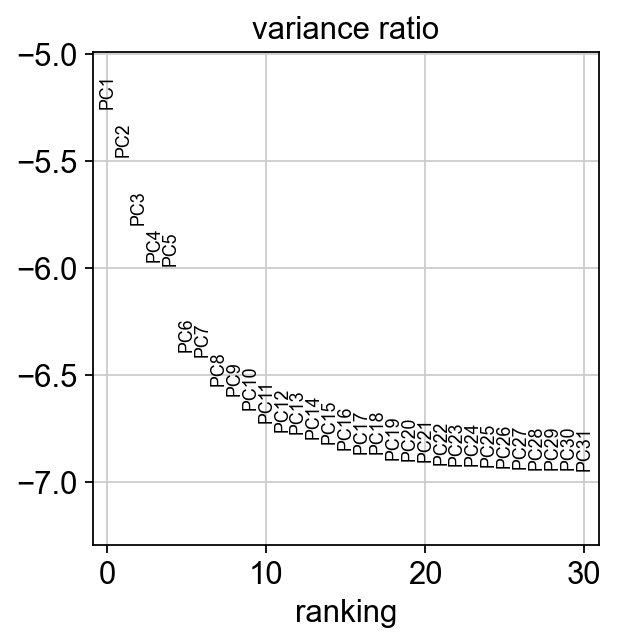

AnnData object with n_obs × n_vars = 28892 × 5112
    obs: 'NRP', 'age_group', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'type', 'version', 'scNym', 'scNym_confidence', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_states_colors', 'scNym_colors', 'scNym_probabilities', 'log1p', 'hvg', 'pca', 'tsne'
    obsm: 'X_pca', 'X_scnym', 'X_umap', 'X_tsne'
    varm: 'PCs'

In [31]:
#Estimates of Principal components contribution to the total variance of the data
sc.pl.pca_variance_ratio(immune, log=True)

#Saving results
immune.write(results_file)
immune

In [32]:
#COMPUTING NEIGHBOUIRHOOD GRAPH#

#General method
sc.pp.neighbors(immune)
immune
#Can add n_neighbors and n_pca parameters if we would like to consider making clusters based on given params#

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


AnnData object with n_obs × n_vars = 28892 × 5112
    obs: 'NRP', 'age_group', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'type', 'version', 'scNym', 'scNym_confidence', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_states_colors', 'scNym_colors', 'scNym_probabilities', 'log1p', 'hvg', 'pca', 'tsne', 'neighbors'
    obsm: 'X_pca', 'X_scnym', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
#Computing by bbknn - Batch balanced KNN

bbknn_data = sc.external.pp.bbknn(immune, batch_key= 'cell_source')

bbknn_data

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


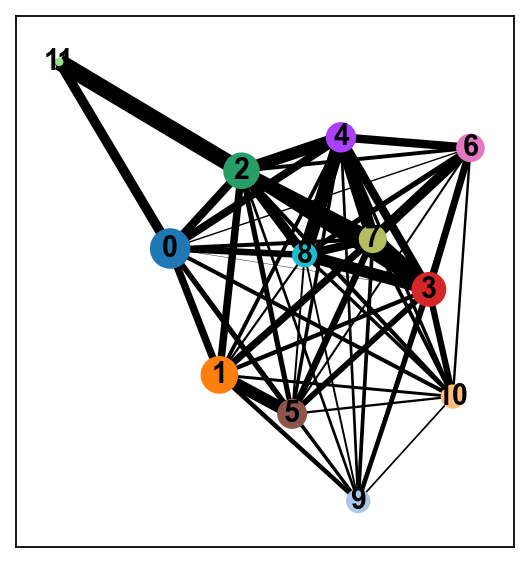

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


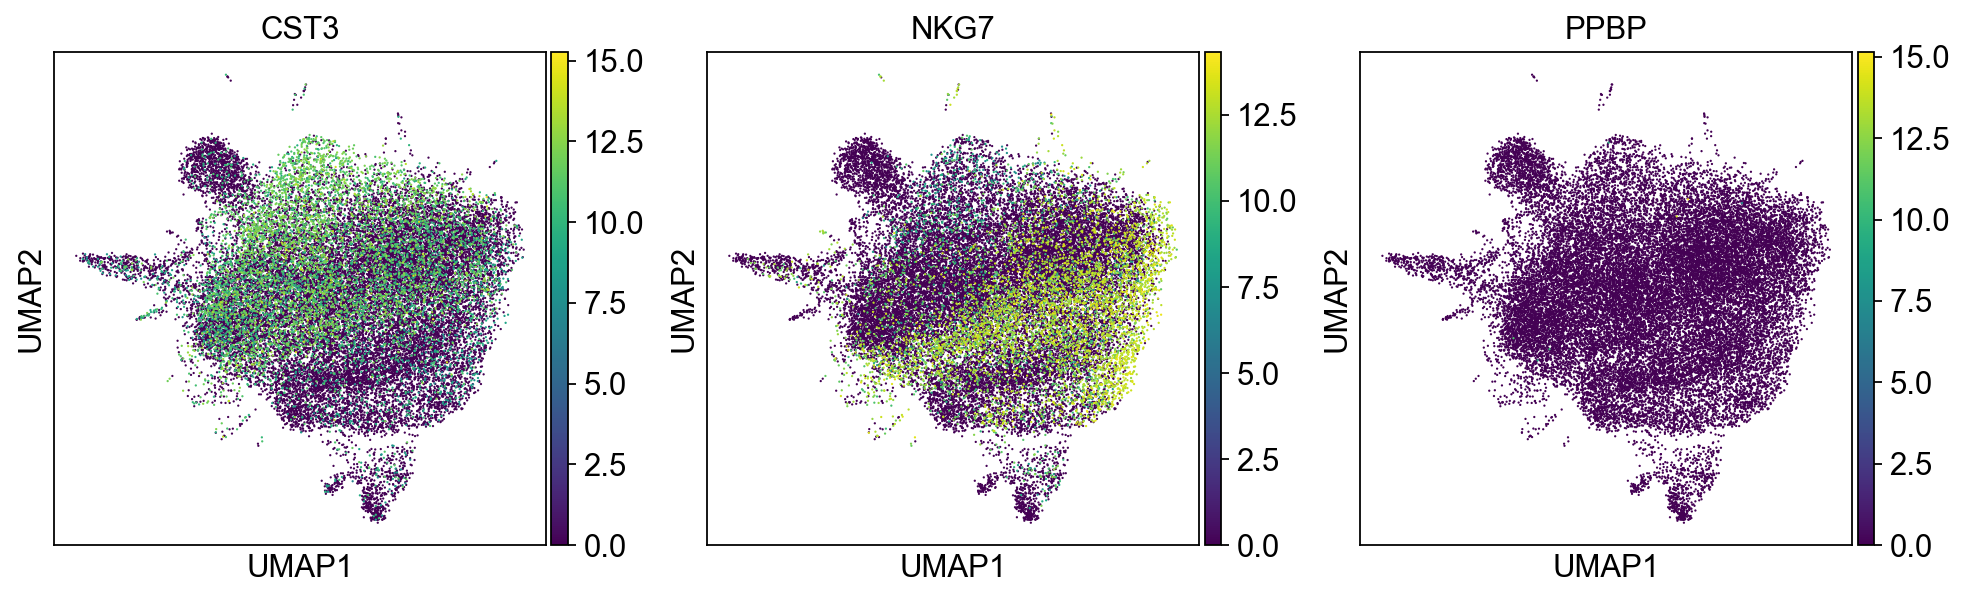

In [34]:
#EMBEDDING THE NEIGHBOURHOOD GRAPH

#Assinging cells to clusters
sc.tl.louvain(immune)

#Partioning data and identifying relationships between clusters
sc.tl.paga(immune)
sc.pl.paga(immune)

#Data visualization
sc.tl.umap(immune)

#Giving colour codes for better visulauization based on genes
sc.pl.umap(immune, color=["CST3", "NKG7", "PPBP"])


running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


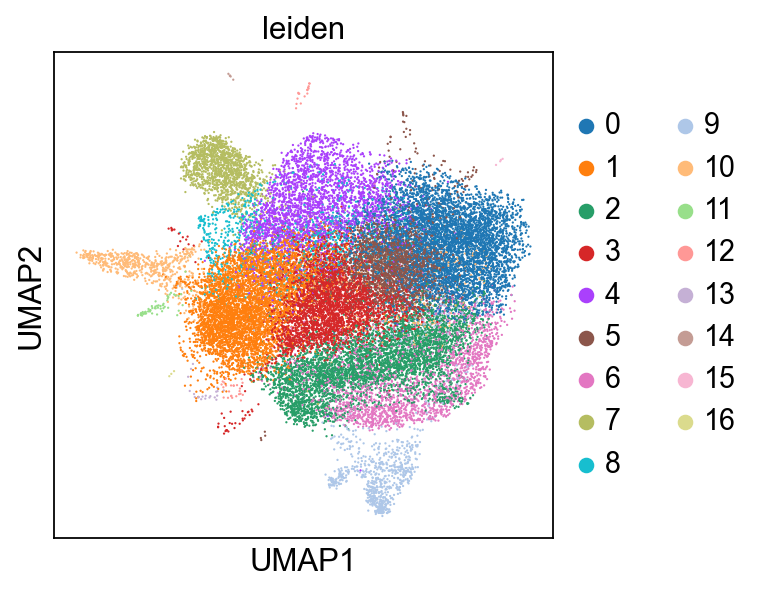

AAAGTGAAGTCGGCCT-1-H0015_apex         2
AAATGGAAGGTCCCTG-1-H0015_apex         2
AAATGGAGTTGTCTAG-1-H0015_apex         6
AACAACCGTAATTGGA-1-H0015_apex         5
AAGACTCTCAGGACGA-1-H0015_apex         5
                                     ..
CTCTCAGAGCATTTGC-1-HCAHeart8102862    4
GAGGGTAGTGCCTTCT-1-HCAHeart8102862    5
GGAGCAACAAATCGGG-1-HCAHeart8102862    4
GTGCACGTCGAGTGGA-1-HCAHeart8102862    1
TCAGCAAGTCCAAATC-1-HCAHeart8102862    9
Name: leiden, Length: 28892, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

In [35]:
##CLUSTERING NEIGHBORHOOD GRAPH#

#Recommendded method Leiden graph-clustering method
sc.tl.leiden(
    immune,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

sc.pl.umap(immune, color=["leiden"])

#To see the cluster labels
immune.obs['leiden']

In [36]:
#Saving file
immune.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


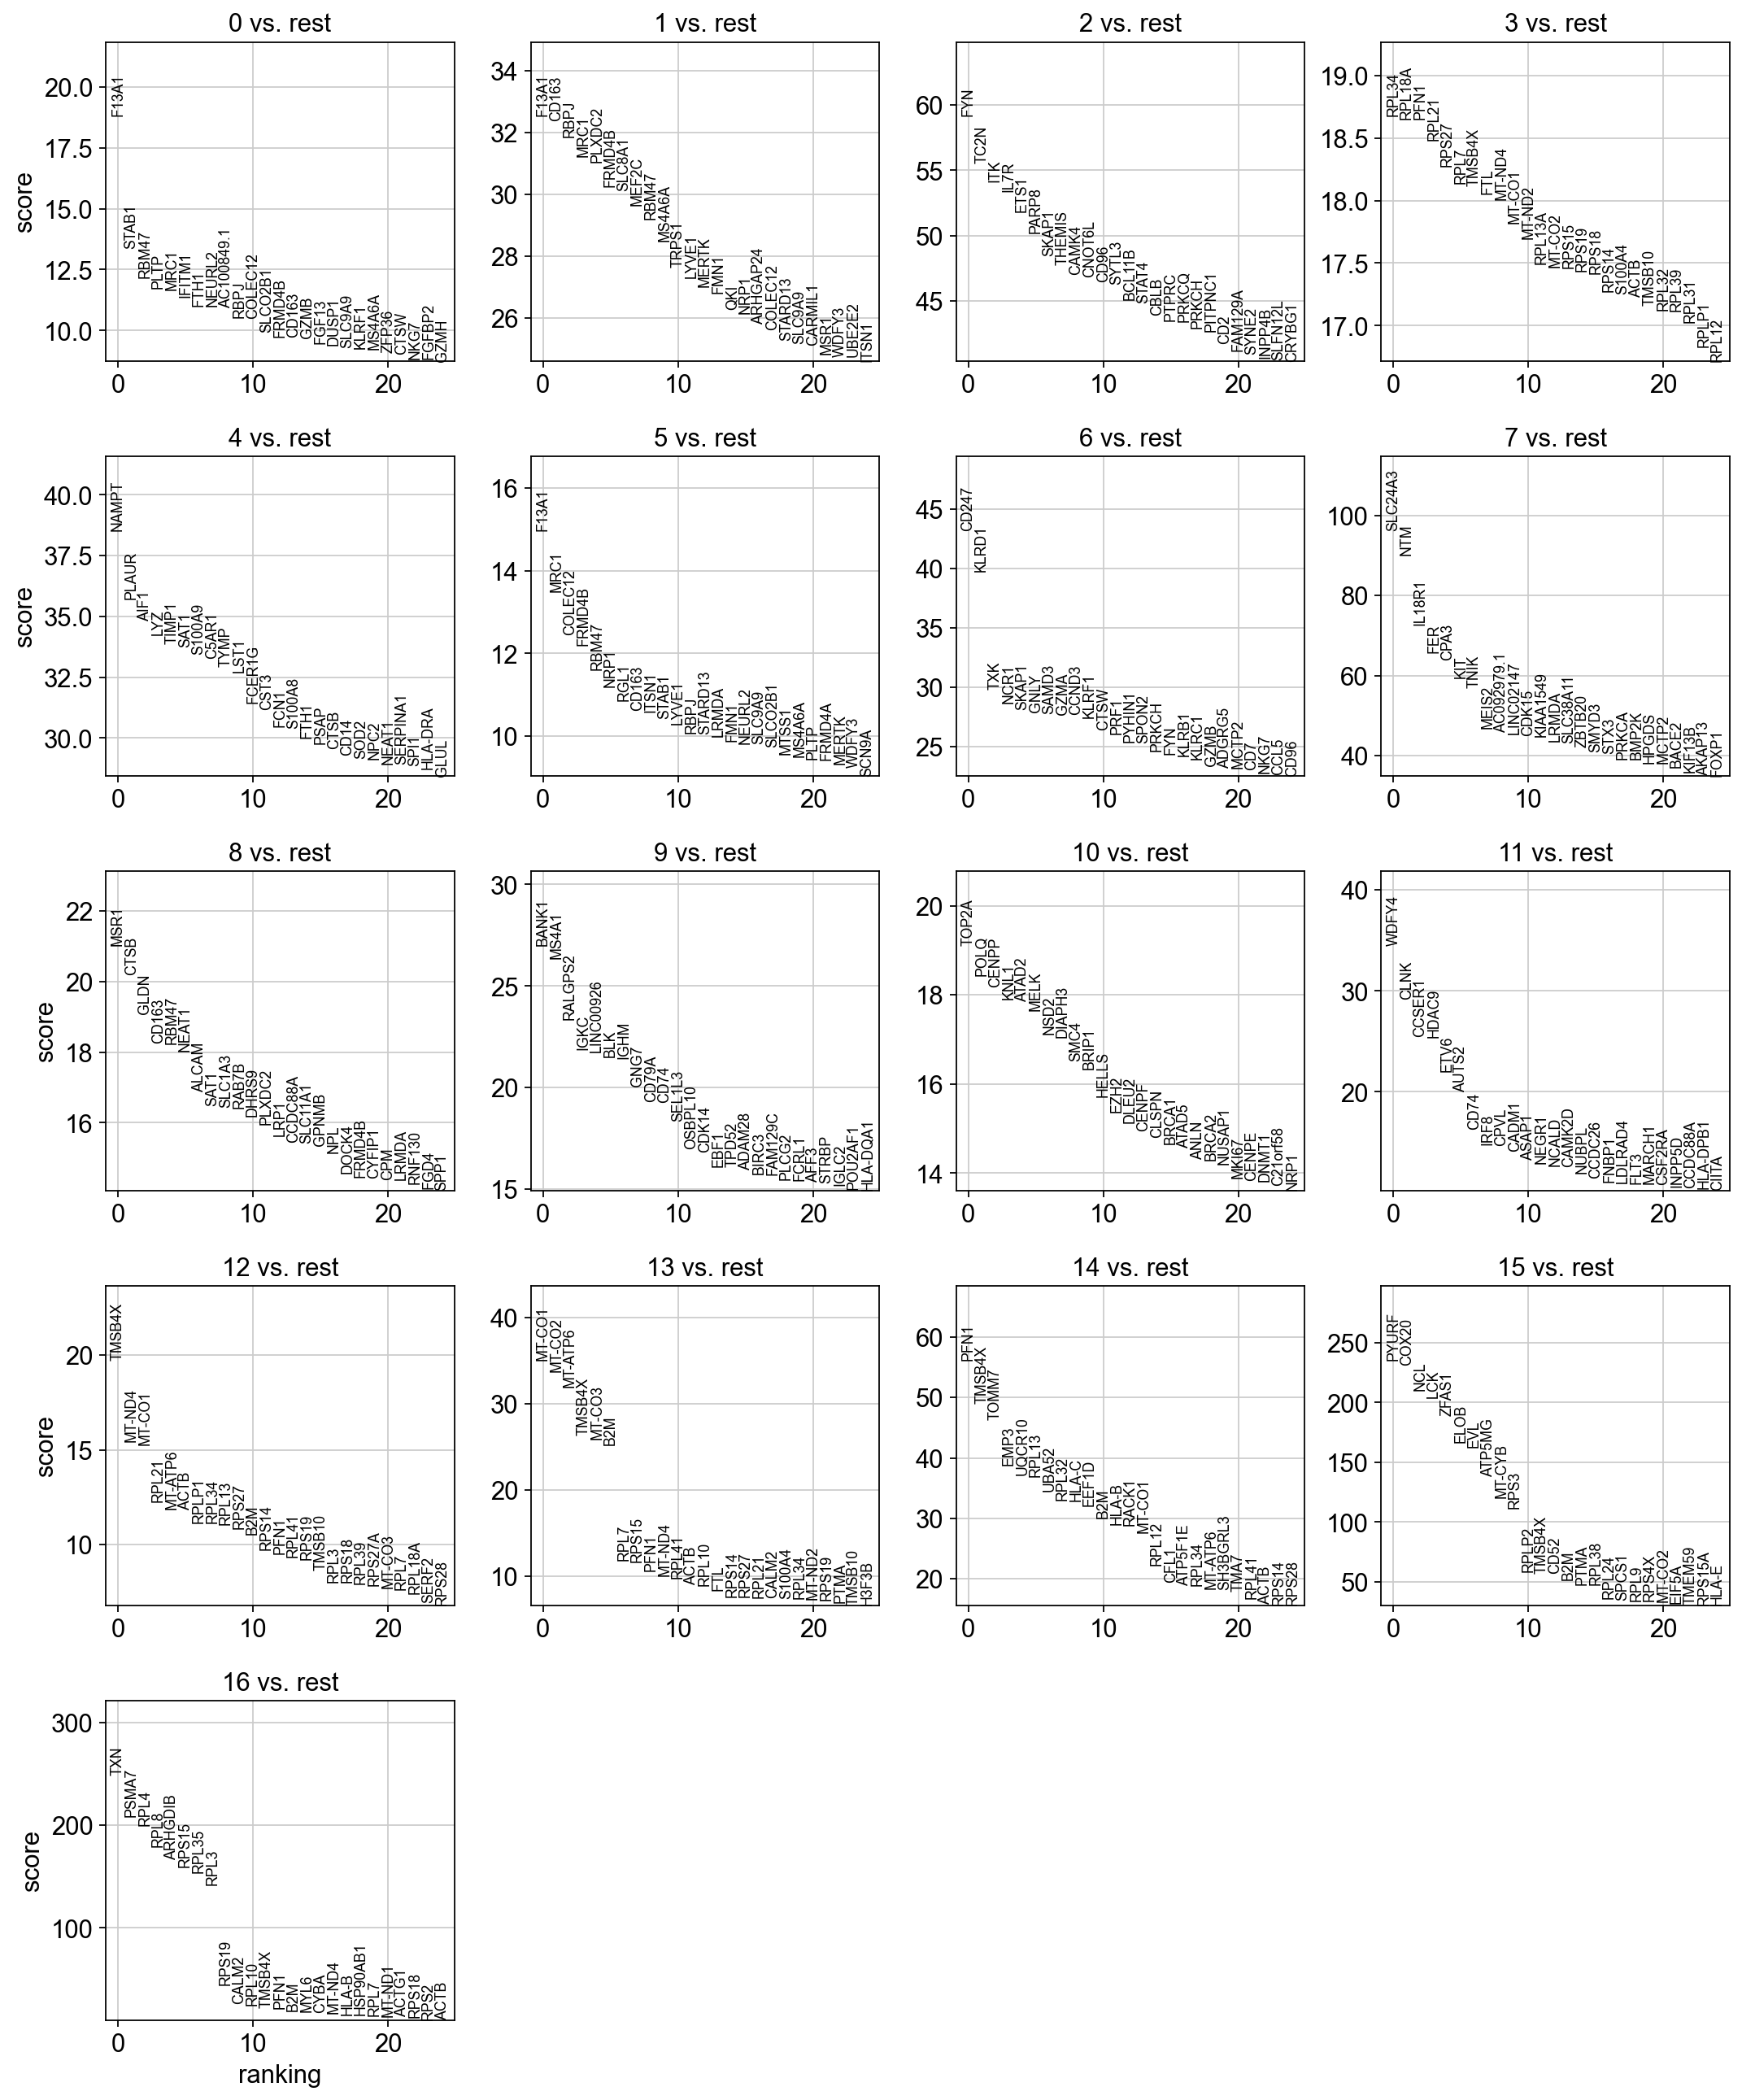

In [37]:
#FINDING MARKER GENES#

#Ranking genes using t-test
sc.tl.rank_genes_groups(immune, "leiden", method="t-test")

#Plotting 
sc.pl.rank_genes_groups(immune, n_genes=25, sharey=False)

ranking genes


/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:25)


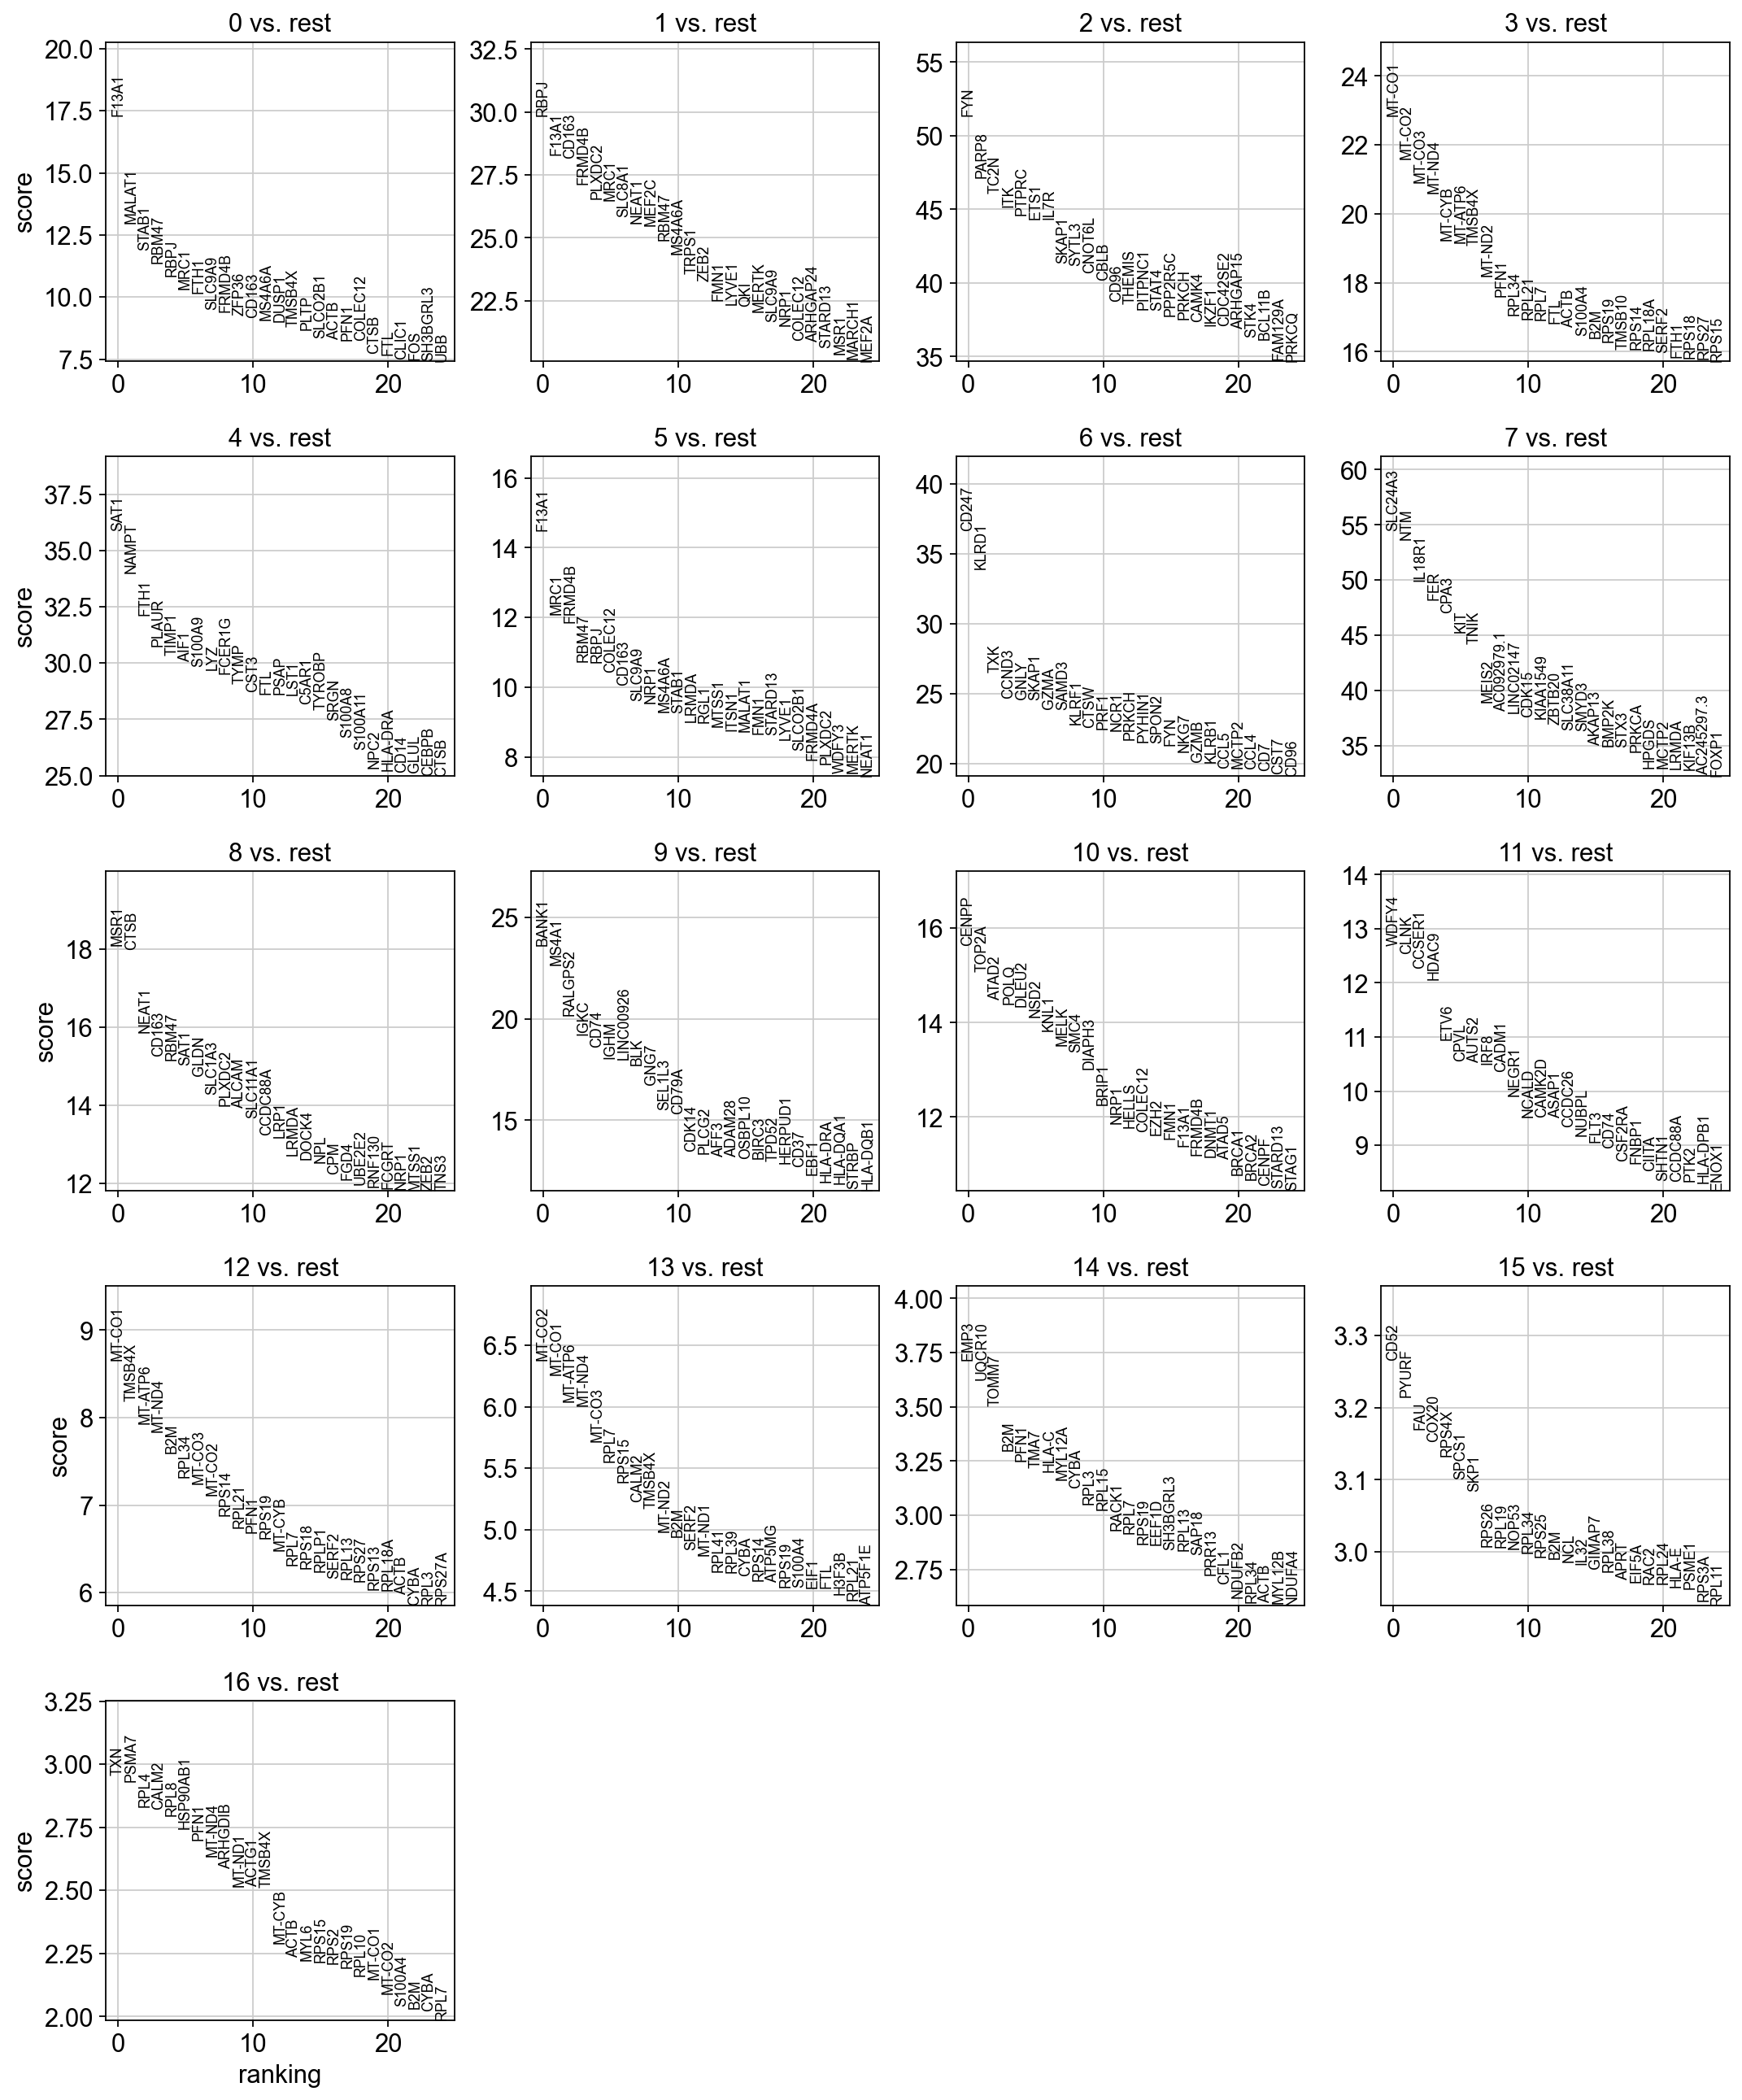

In [38]:
#Ranking genes using wilcoxon method
sc.tl.rank_genes_groups(immune, "leiden", method="wilcoxon")

#Plotting 
sc.pl.rank_genes_groups(immune, n_genes=25, sharey=False)

#Saving data
immune.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:01:04)


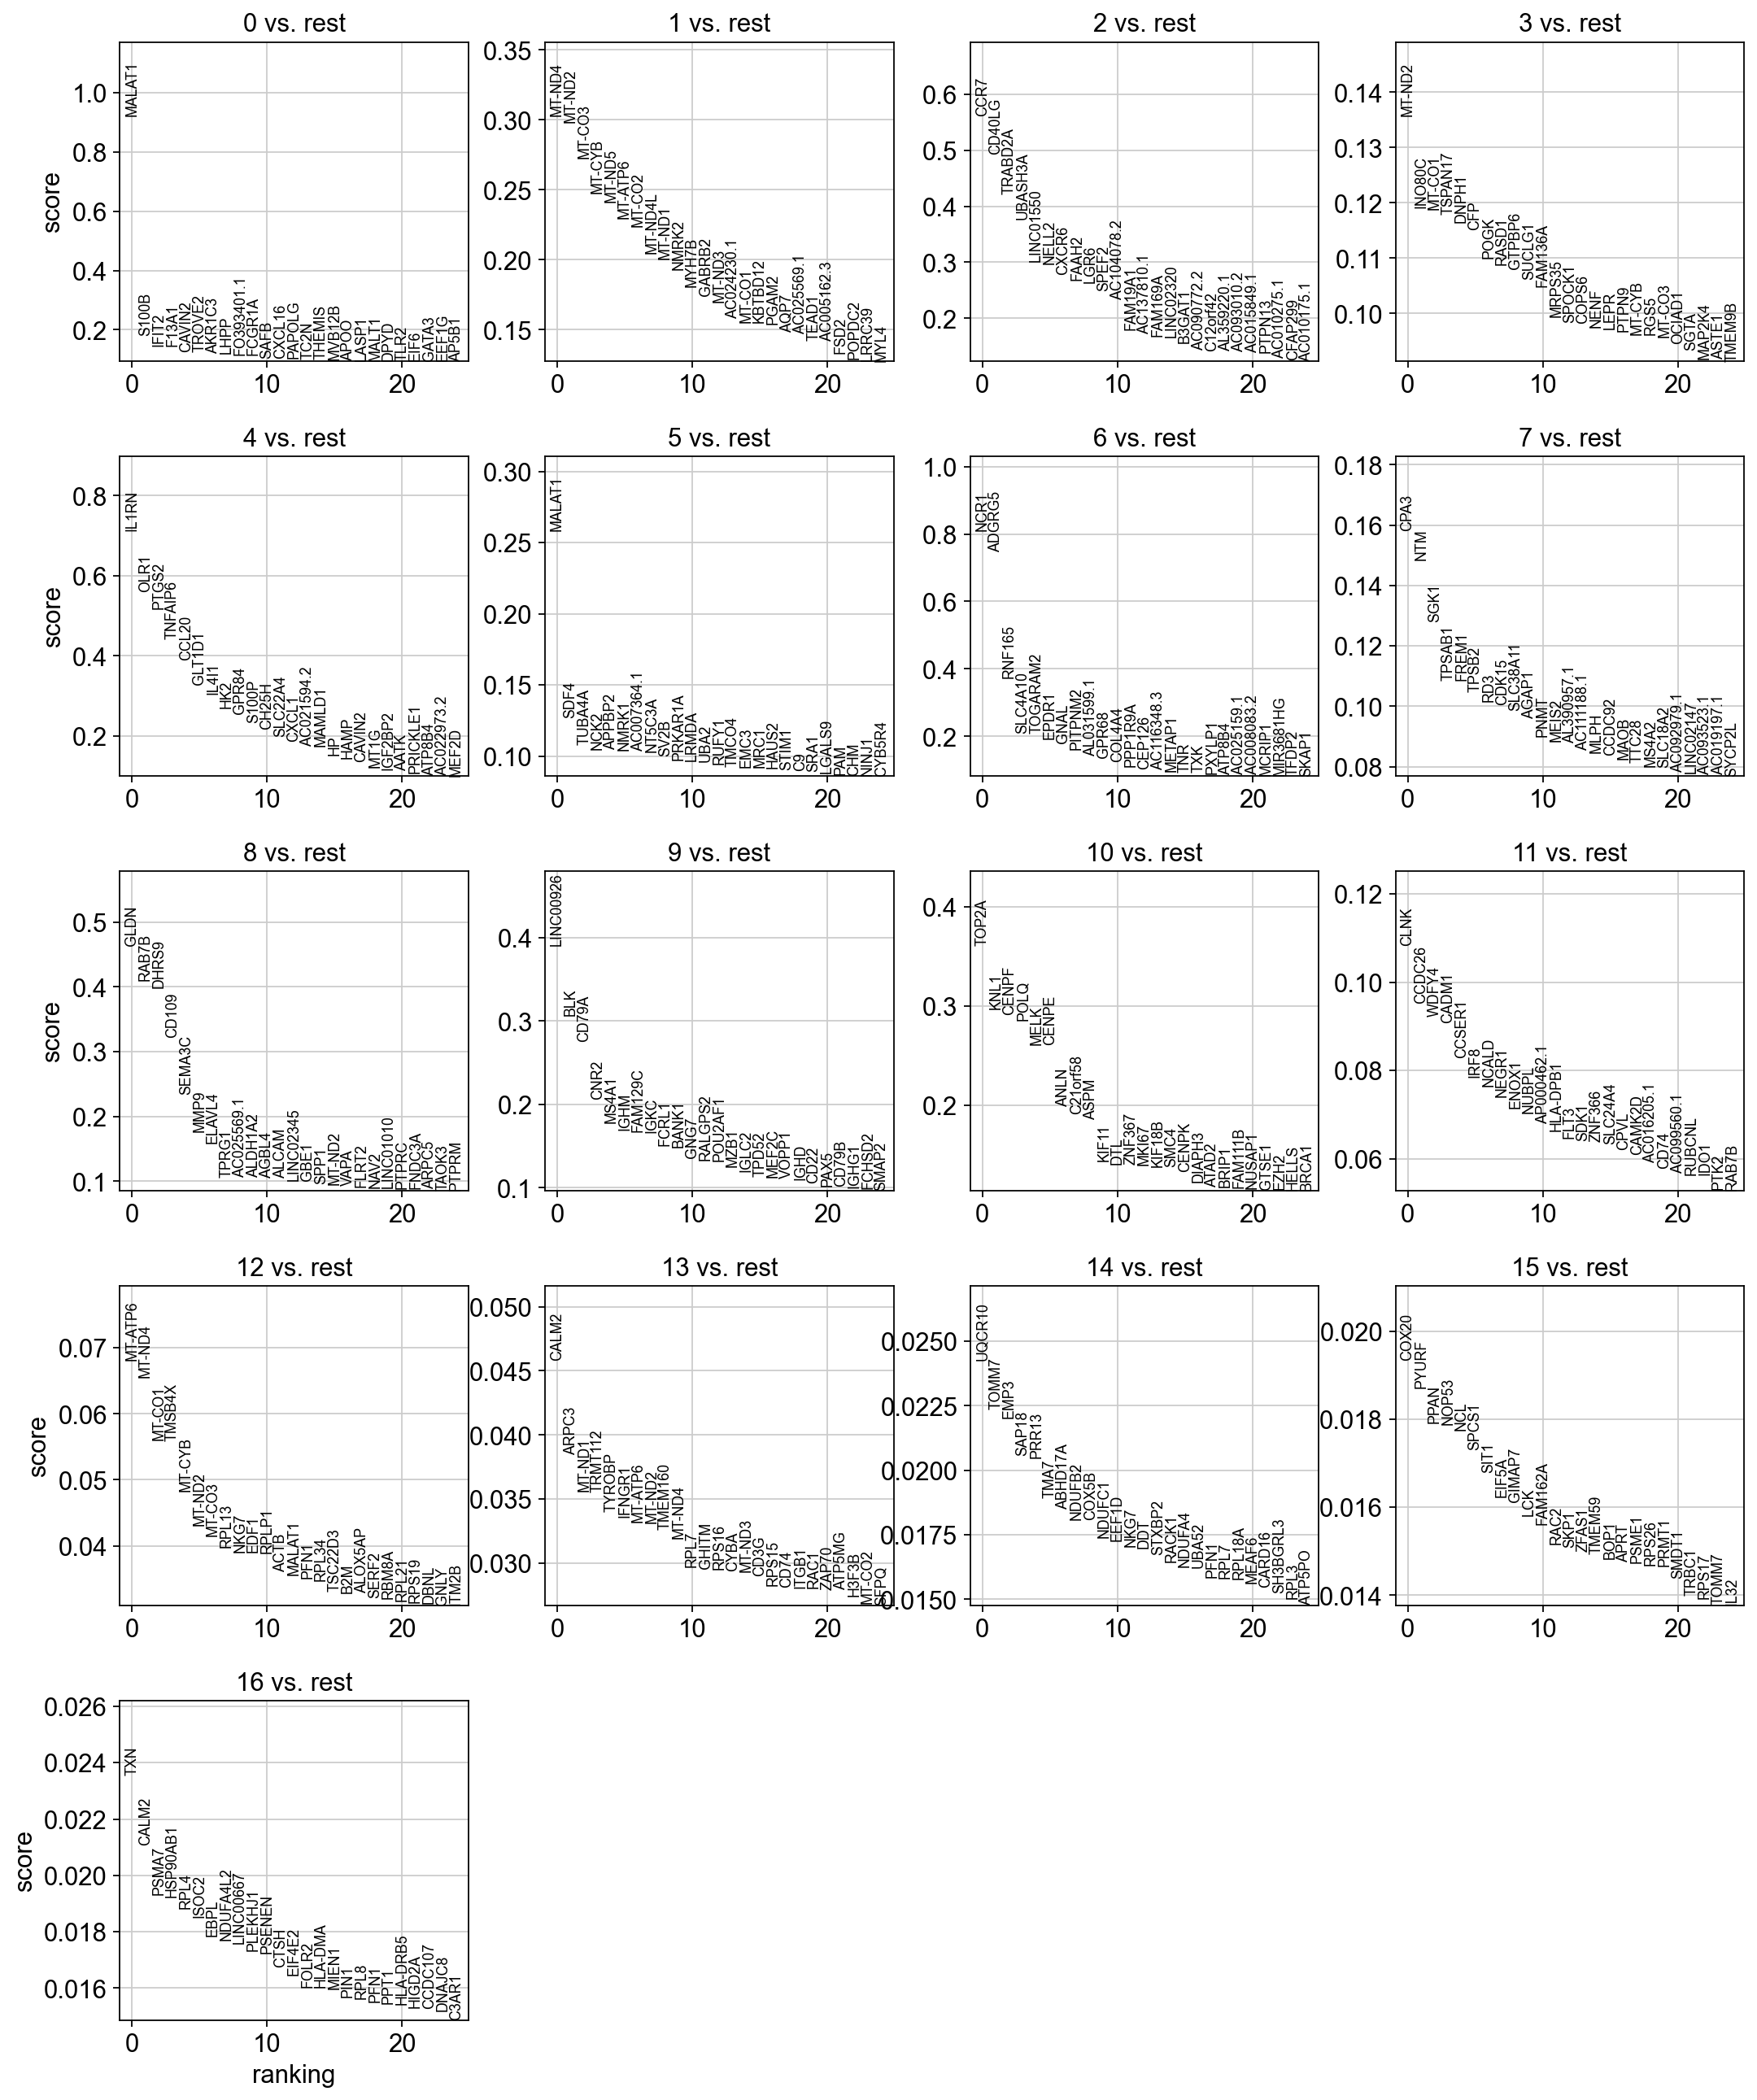

In [39]:
#Using logistic regression
sc.tl.rank_genes_groups(immune, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(immune, n_genes=25, sharey=False)

In [40]:
#To get list of gene names across clusters
pd.DataFrame(immune.uns["rank_genes_groups"]["names"])

#Can add .head(10) at the end to give output of only 10 hits

0       1          2        3        4       5         6       7  \
0       MALAT1  MT-ND4       CCR7   MT-ND2    IL1RN  MALAT1      NCR1    CPA3   
1        S100B  MT-ND2     CD40LG   INO80C     OLR1    SDF4    ADGRG5     NTM   
2        IFIT2  MT-CO3    TRABD2A   MT-CO1    PTGS2  TUBA4A    RNF165    SGK1   
3        F13A1  MT-CYB    UBASH3A  TSPAN17  TNFAIP6    NCK2   SLC4A10  TPSAB1   
4       CAVIN2  MT-ND5  LINC01550    DNPH1    CCL20  APPBP2  TOGARAM2   FREM1   
...        ...     ...        ...      ...      ...     ...       ...     ...   
26670  MT-ATP6    SMC4       PBX3    PTGS2   CORO1C  NDFIP1    CAMK1D   NEAT1   
26671   MT-ND1   PTGS2     TMEM11     CCR7    PSMA4   IFIT2   ST6GAL1  MT-CO1   
26672   MT-CYB    OLR1     ELOVL6   ADGRG5    ITFG1   CCND2  SLC38A10  MT-CO3   
26673   MT-ND4   IL1RN     ADGRG5     OLR1    DOCK5  MT-ND2    THEMIS     B2M   
26674   MT-ND2  MALAT1       NCR1    IL1RN     NDE1  CAVIN2   SERINC3  MALAT1   

            8          9       10      11        12       13      14      15  \
0        GLDN  LINC00926    TOP2A    CLNK   MT-ATP6    CALM2  UQCR10   COX20   
1       RAB7B        BLK     KNL1  CCDC26    MT-ND4    ARPC3   TOMM7   PYURF   
2       DHRS9      CD79A    CENPF   WDFY4    MT-CO1   MT-ND1    EMP3    PPAN   
3       CD109       CNR2     POLQ   CADM1    TMSB4X  TRMT112   SAP18   NOP53   
4      SEMA3C      MS4A1     MELK  CCSER1    MT-CYB   TYROBP   PRR13     NCL   
...       ...        ...      ...     ...       ...      ...     ...     ...   
26670   FARP1       GNAQ     PRKN    DPYD  ARHGAP15    CELF2   FKBP5    RBPJ   
26671   SCN9A    ARL6IP5   RNF115   F13A1   GADD45B    RPL18   CELF2   FOXP1   
26672    TCF4        FYN    DHX36    ZEB2    ATP5PO    FOXP1  AKAP13   FKBP5   
26673   STAG1      STAT4    MGAT1  FRMD4B    COX6B1    RPL29   NEAT1   NEAT1   
26674  PRRC2B      PRKCH  ANKRD12  MALAT1     EEF1D     GMFG  MALAT1  MALAT1   

             16  
0           TXN  
1         CALM2  
2         PSMA7  
3      HSP90AB1  
4          RPL4  
...         ...  
26670     CELF2  
26671    AKAP13  
26672     MBNL1  
26673     NEAT1  
26674    MALAT1  

[26675 rows x 17 columns]

In [41]:
#Getting table with scores and group
immune = sc.read(results_file)
result = immune.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)
#low p-value indicates that the gene is likely differentially expressed in that cluster compared to others

/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


0_n           0_p     1_n            1_p    2_n  2_p     3_n  \
0   F13A1  4.109561e-67    RBPJ  7.189062e-196    FYN  0.0  MT-CO1   
1  MALAT1  1.646606e-38   F13A1  2.164163e-176  PARP8  0.0  MT-CO2   
2   STAB1  1.340350e-32   CD163  1.774800e-174   TC2N  0.0  MT-CO3   
3   RBM47  6.131944e-30  FRMD4B  4.551978e-162    ITK  0.0  MT-ND4   
4    RBPJ  2.034695e-27  PLXDC2  2.731203e-155  PTPRC  0.0  MT-CYB   

             3_p    4_n            4_p  ...     12_n          12_p     13_n  \
0  1.467087e-115   SAT1  3.379014e-282  ...   MT-CO1  4.703211e-18   MT-CO2   
1  2.252019e-103  NAMPT  8.698618e-254  ...   TMSB4X  2.552119e-16   MT-CO1   
2   4.469184e-97   FTH1  1.757736e-226  ...  MT-ATP6  2.091444e-15  MT-ATP6   
3   2.776408e-94  PLAUR  1.199761e-207  ...   MT-ND4  4.532660e-15   MT-ND4   
4   2.151002e-82  TIMP1  1.956253e-202  ...      B2M  3.099214e-14   MT-CO3   

           13_p    14_n      14_p   15_n      15_p   16_n      16_p  
0  1.749675e-10    EMP3  0.000202   CD52  0.001089    TXN  0.003084  
1  3.788326e-10  UQCR10  0.000290  PYURF  0.001305  PSMA7  0.003379  
2  1.502876e-09   TOMM7  0.000454    FAU  0.001521   RPL4  0.004606  
3  1.866897e-09     B2M  0.000965  COX20  0.001614  CALM2  0.004748  
4  1.068150e-08    PFN1  0.001159  RPS4X  0.001733   RPL8  0.005180  

[5 rows x 34 columns]

ranking genes


/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


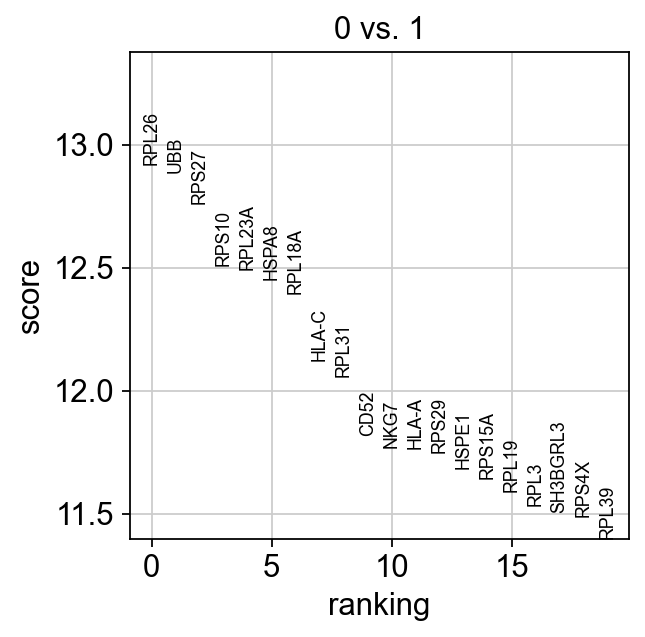

In [42]:
#Comparing between clusters and ranking genes
sc.tl.rank_genes_groups(immune, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(immune, groups=["0"], n_genes=20)

/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


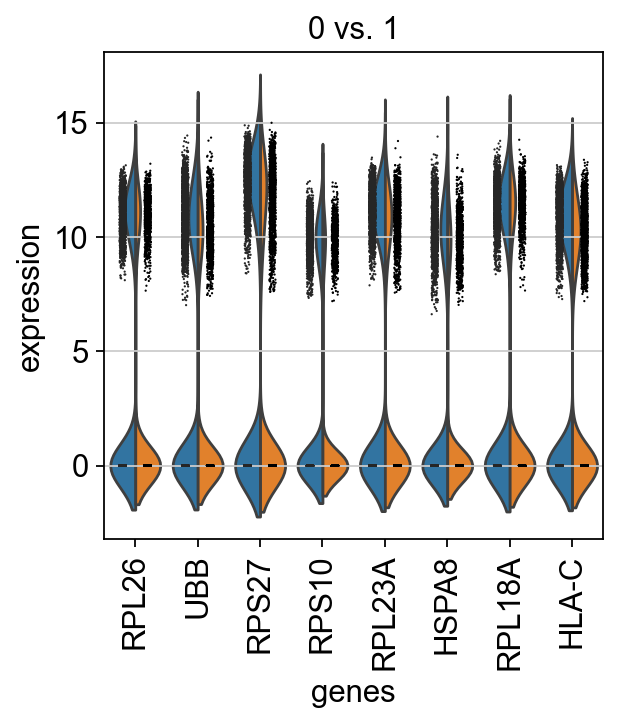

In [43]:
#More detailed view of cluster if required
sc.pl.rank_genes_groups_violin(immune, groups="0", n_genes=8)

/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


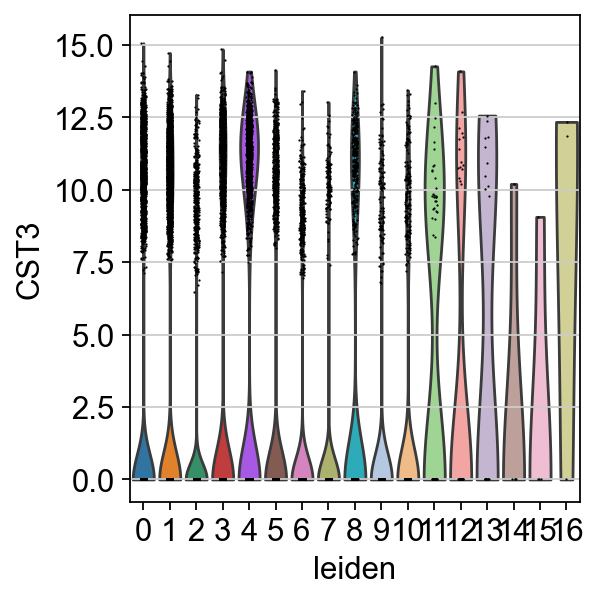

In [44]:
#Visualizing genes across clusters
sc.pl.violin(immune, ["CST3"], groupby="leiden")

/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(

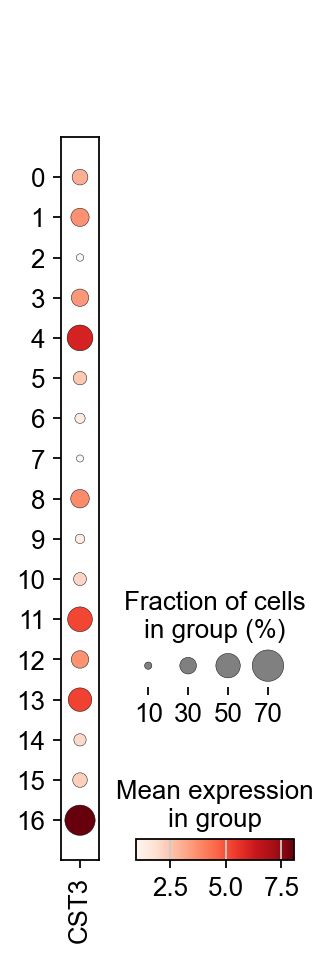

/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _color_df = _matrix.groupby(level=0).median()
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_stacked_violin.py:405: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pd.DataFrame(_matrix.stack(dropna=False))
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. As

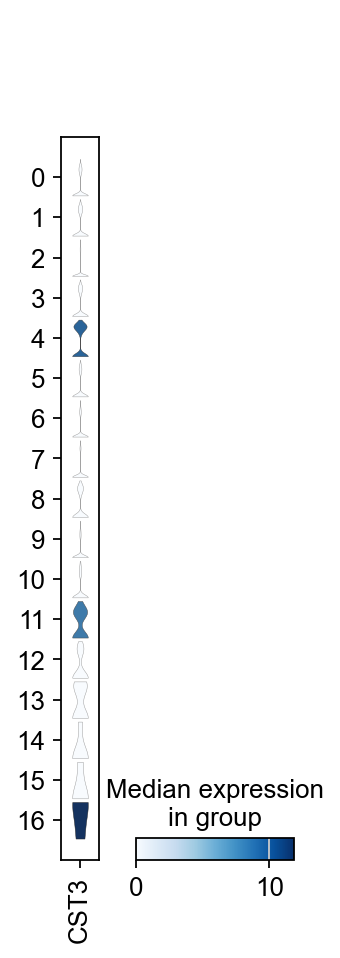

In [45]:
#Visualizing gene across groups in dotplot
sc.pl.dotplot(immune, 'CST3', groupby="leiden")

#Visualizing gene across groups in violin plot
sc.pl.stacked_violin(immune, 'CST3', groupby="leiden");

In [46]:
##SAVING FILE
immune.write(results_file, compression="gzip")